In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dfs = []
for split in ('train', 'test', 'val'):
    source_file = f'../data/processed/MMFakeBench_graphs/{split}_dbpedia_split.json'
    df = pd.read_json(source_file)
    dfs.append(df.assign(split=split))
    print(split, ':', df.shape)

df = pd.concat(dfs, ignore_index=True)
print(df.shape)
df.head()

train : (7267, 12)
test : (819, 12)
val : (808, 12)
(8894, 13)


,image_path,full_image_path,text_raw,idx,image_source,image_real,claim_real,mismatch,overall_truth,text_source,gt_answsers,fake_cls,split
0,fake/chatgpt_match_test_500/chatgpt_match_test...,/cluster/home/alexaamr/forensics_imt4210_truth...,Hillary Clinton Email Scandal Deepens: Calls f...,5030,Repurposed Image,True,False,False,False,GPT-generated Rumor,Fake,textual_veracity_distortion,train
1,real/guardian_test_500/guardian_test_289.png,/cluster/home/alexaamr/forensics_imt4210_truth...,Rory McIlroy was 21 shots behind the leader af...,1789,VisualNews,True,True,False,True,VisualNews,True,original,train
2,fake/DGM4_text_edit_senti_test_500/DGM4_text_e...,/cluster/home/alexaamr/forensics_imt4210_truth...,Kelly Hoppen left with stepdaughter Sienna Mil...,9695,DGM4,True,True,True,False,DGM4,Fake,mismatch,train
3,fake/rumor_match_test_750/rumor_match_test_609...,/cluster/home/alexaamr/forensics_imt4210_truth...,Alex Rodriguez slams report he's threatening t...,4609,Repurposed Image,True,False,False,False,Fakenewsnet,Fake,textual_veracity_distortion,train
4,fake/coco_text_edit_test_500/coco_text_edit_te...,/cluster/home/alexaamr/forensics_imt4210_truth...,An ornate fern garden wall outside in the garden.,8654,COCO-Counterfactuals,True,True,True,False,COCO-Counterfactuals,Fake,mismatch,train


# Source file dataset

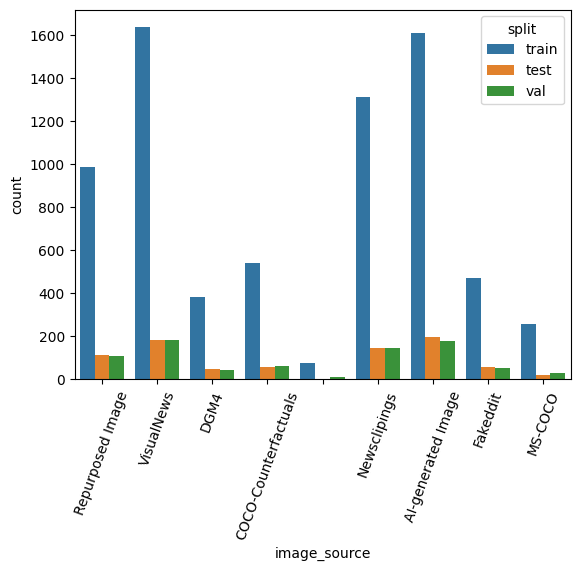

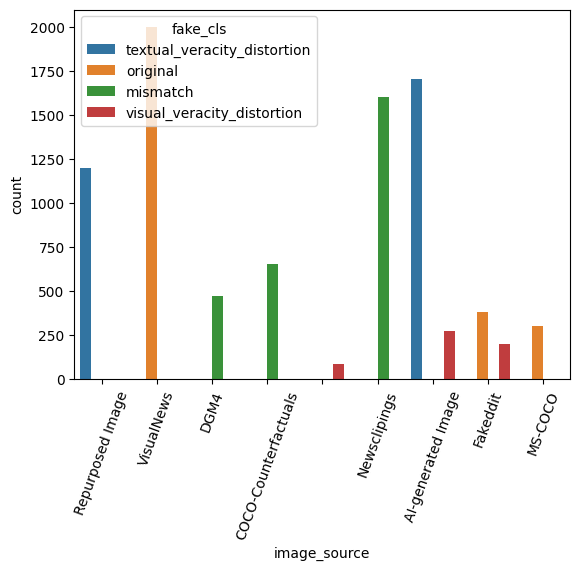

In [7]:
fig, ax = plt.subplots()
sns.countplot(df, x='image_source', hue='split')
ax.tick_params(axis='x', labelrotation=70)

fig, ax = plt.subplots()
sns.countplot(df, x='image_source', hue='fake_cls')
ax.tick_params(axis='x', labelrotation=70)

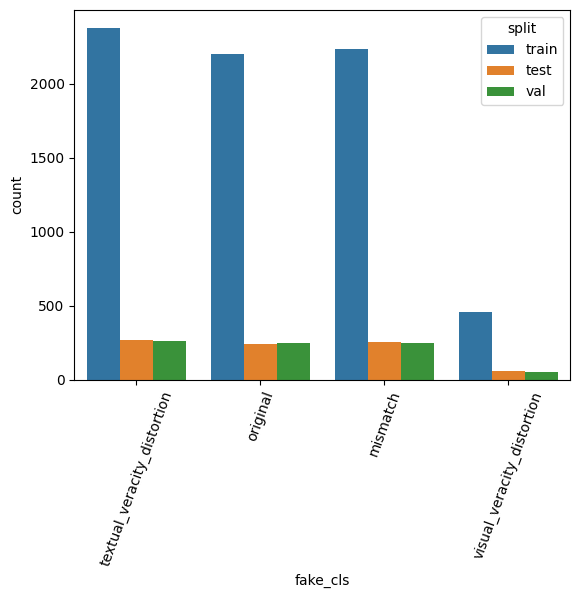

In [8]:
fig, ax = plt.subplots()
sns.countplot(df, x='fake_cls', hue='split')
ax.tick_params(axis='x', labelrotation=70)

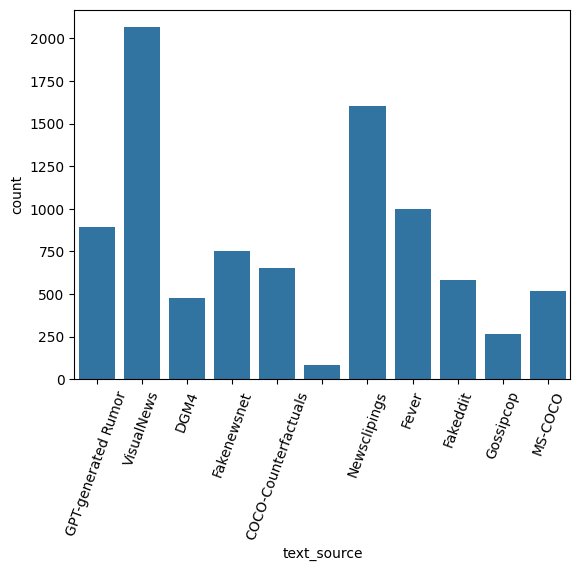

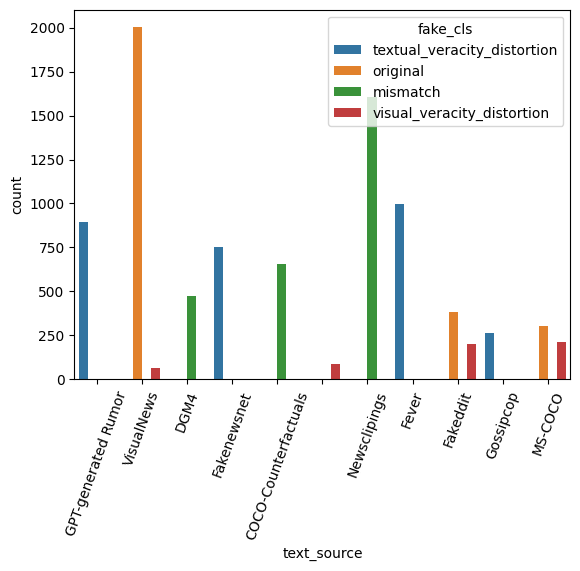

In [9]:
fig, ax = plt.subplots()
sns.countplot(df, x='text_source')
ax.tick_params(axis='x', labelrotation=70)

fig, ax = plt.subplots()
sns.countplot(df, x='text_source', hue='fake_cls')
ax.tick_params(axis='x', labelrotation=70)

# Create a val split from train split

In [42]:
df['strata'] = df['text_source'].astype(str) + "_" + df['image_source'].astype(str) + "_" + df['fake_cls'].astype(str)

<Axes: xlabel='count', ylabel='strata'>

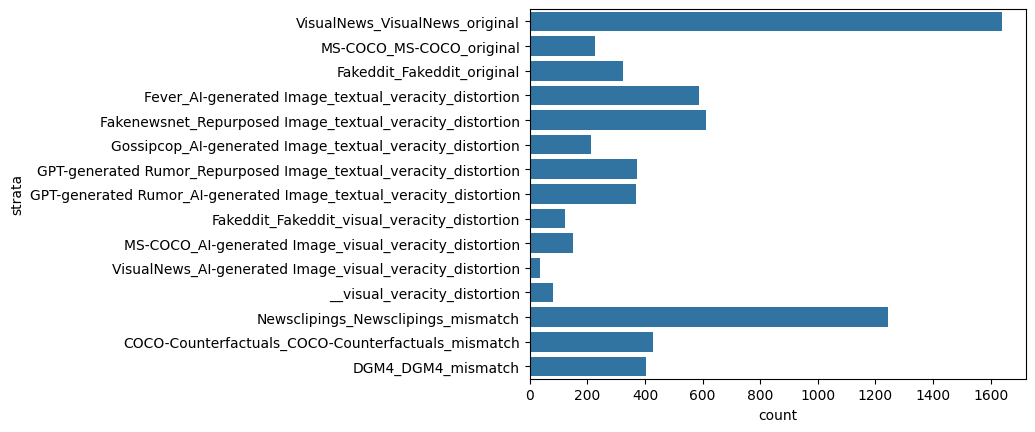

In [43]:
fig, ax = plt.subplots()
sns.countplot(df, y='strata')


In [44]:
from sklearn.model_selection import train_test_split

train_new, val = train_test_split(
    df,
    test_size=0.15,               
    random_state=42,             # for reproducibility
    stratify=df['strata']        # stratified split
)

train_new = train_new.drop(columns=['strata'])
val = val.drop(columns=['strata'])

print(train_new.shape)
print(val.shape)

(5780, 12)
(1021, 12)


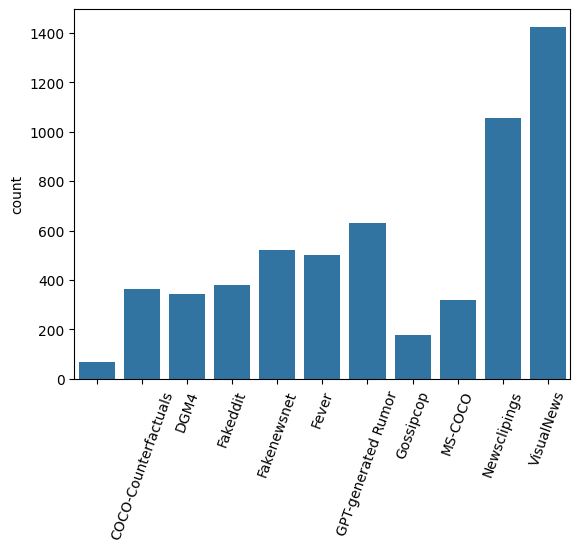

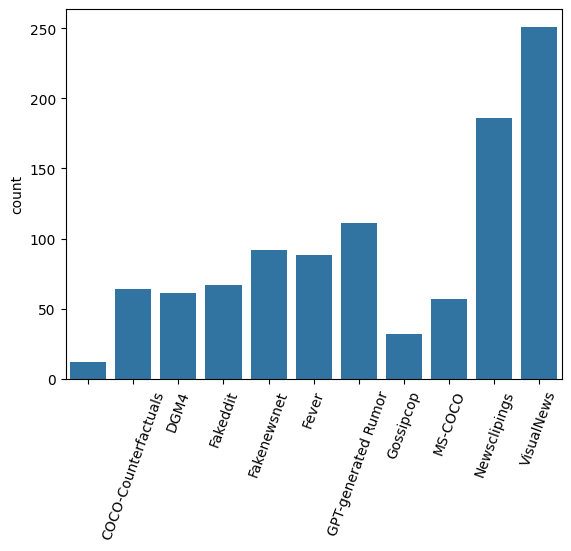

In [47]:
fig, ax = plt.subplots()
sns.countplot(train_new, x=sorted(train_new['text_source']))
ax.tick_params(axis='x', labelrotation=70)

fig, ax = plt.subplots()
sns.countplot(val, x=sorted(val['text_source'].to_list()))
ax.tick_params(axis='x', labelrotation=70)

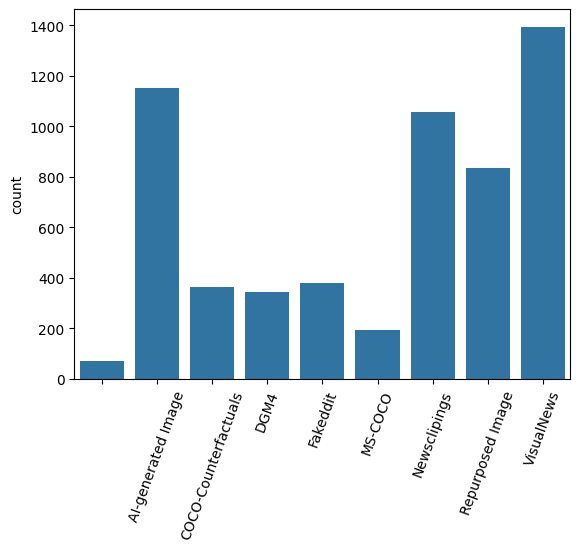

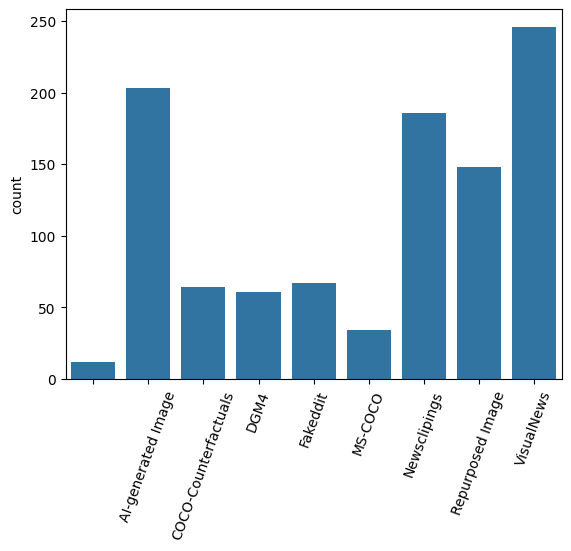

In [48]:
fig, ax = plt.subplots()
sns.countplot(train_new, x=sorted(train_new['image_source']))
ax.tick_params(axis='x', labelrotation=70)

fig, ax = plt.subplots()
sns.countplot(val, x=sorted(val['image_source'].to_list()))
ax.tick_params(axis='x', labelrotation=70)

# Can random guess be enough?

In [4]:
df_gt = df[['image_real', 'claim_real', 'mismatch', 'overall_truth']]

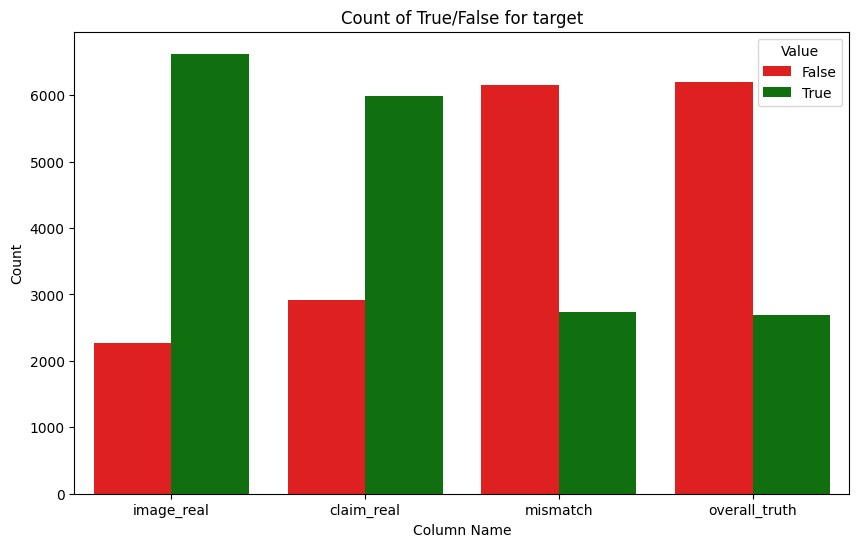

In [5]:
# Melt the DataFrame to long format for seaborn
df_melted = df_gt.melt(var_name='variable', value_name='value')

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_melted,
    x='variable',
    hue='value',
    palette={True: 'green', False: 'red'}
)

plt.title('Count of True/False for target')
plt.xlabel('Column Name')
plt.ylabel('Count')
plt.legend(title='Value', labels=['False', 'True'])

plt.show()

In [6]:

# Calculate random baseline metrics
random_metrics = {}
for col in df_gt.columns:
    p = df_gt[col].mean()  # Empirical probability of True
    random_metrics[col] = {
        'accuracy': max(p, 1 - p),  # Best random accuracy
        'precision': p,              # Random precision
        'recall': p,                 # Random recall
        'f1': 2 * p / (p + 1),       # Random F1
    }

# Compare
for col in df_gt.columns:
    print(f"Column: {col}")
    print(f"Random Baseline Accuracy: {random_metrics[col]['accuracy']:.2f}")
    print(f"Random Baseline F1      : {random_metrics[col]['f1']:.2f}\n")

Column: image_real
Random Baseline Accuracy: 0.75
Random Baseline F1      : 0.85

Column: claim_real
Random Baseline Accuracy: 0.67
Random Baseline F1      : 0.80

Column: mismatch
Random Baseline Accuracy: 0.69
Random Baseline F1      : 0.47

Column: overall_truth
Random Baseline Accuracy: 0.70
Random Baseline F1      : 0.46



---

Comments: 

> Results are much lower than model's results, the model is not random guessing.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize dictionaries to store baseline metrics
baseline_1_metrics = {}
baseline_0_metrics = {}

for col in df_gt.columns:
    # Always predict 1
    baseline_1_metrics[col] = {
        'accuracy': accuracy_score(df_gt[col], [True] * len(df_gt)),
        'precision': precision_score(df_gt[col], [True] * len(df_gt), zero_division=0),
        'recall': recall_score(df_gt[col], [True] * len(df_gt), zero_division=0),
        'f1': f1_score(df_gt[col], [True] * len(df_gt), zero_division=0),
    }

    # Always predict 0
    baseline_0_metrics[col] = {
        'accuracy': accuracy_score(df_gt[col], [False] * len(df_gt)),
        'precision': precision_score(df_gt[col], [False] * len(df_gt), zero_division=0),
        'recall': recall_score(df_gt[col], [False] * len(df_gt), zero_division=0),
        'f1': f1_score(df_gt[col], [False] * len(df_gt), zero_division=0),
    }

# Compare with your model's metrics
for col in df_gt.columns:
    print(f"Column: {col}")
    print(f"Random Accuracy: {random_metrics[col]['accuracy']:.2f}, Always 1: {baseline_1_metrics[col]['accuracy']:.2f}, Always 0: {baseline_0_metrics[col]['accuracy']:.2f}")
    print(f"Random F1: {random_metrics[col]['f1']:.2f}, Always 1: {baseline_1_metrics[col]['f1']:.2f}, Always 0: {baseline_0_metrics[col]['f1']:.2f}\n")


Column: image_real
Random Accuracy: 0.75, Always 1: 0.75, Always 0: 0.25
Random F1: 0.85, Always 1: 0.85, Always 0: 0.00

Column: claim_real
Random Accuracy: 0.67, Always 1: 0.67, Always 0: 0.33
Random F1: 0.80, Always 1: 0.80, Always 0: 0.00

Column: mismatch
Random Accuracy: 0.69, Always 1: 0.31, Always 0: 0.69
Random F1: 0.47, Always 1: 0.47, Always 0: 0.00

Column: overall_truth
Random Accuracy: 0.70, Always 1: 0.30, Always 0: 0.70
Random F1: 0.46, Always 1: 0.46, Always 0: 0.00

